In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from clustering_comparison import *

In [22]:
M = loadmat('allpp.mat')['Z'][:,:]

In [153]:
plt.figure()
n = 6
n0 = 6

plt.subplot(2,6,n)
plt.imshow(np.reshape(M[:,5], (20,68), order="F"),cmap=)
plt.axis('off')
plt.subplot(2,6,n+n0)
plt.hist(M[:,5])

plt.subplot(2,6,n)
plt.imshow(np.reshape(M[:,4], (20,68), order="F"),cmap=)
plt.axis('off')

plt.subplot(2,6,n+n0)
plt.hist(M[:,5])


plt.subplot(2,6,n)
plt.imshow(np.reshape(M[:,3], (20,68), order="F"),cmap=)
plt.axis('off')

plt.subplot(2,6,n+n0)
plt.hist(M[:,5])


plt.subplot(2,6,n)
plt.imshow(np.reshape(M[:,2], (20,68), order="F"),cmap=)
plt.axis('off')

plt.subplot(2,6,n+n0)
plt.hist(M[:,5])

n -= 1

plt.subplot(2,6,n)
plt.imshow(np.reshape(M[:,1], (20,68), order="F"),cmap=)
plt.axis('off')

plt.subplot(2,6,n+n0)
plt.hist(M[:,5])

n -= 1


plt.subplot(2,6,n)
plt.imshow(np.reshape(M[:,0], (20,68), order="F"),cmap=)
plt.axis('off')
plt.savefig('reds.png')

plt.subplot(2,6,n+n0)
plt.hist(M[:,5])

SyntaxError: invalid syntax (<ipython-input-153-3d705e619c76>, line 8)

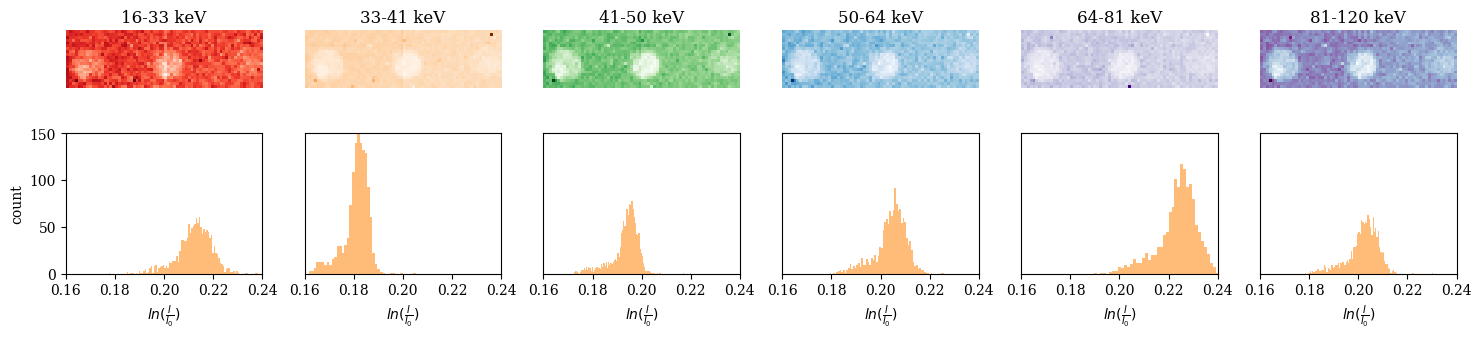

In [26]:
images_dir = '../../clustering_figures/'

cmaps = ['BuPu','Purples','Blues','Greens','Oranges','Reds']
ebins = ['16-33 keV','33-41 keV','41-50 keV','50-64 keV','64-81 keV','81-120 keV']
plt.figure(figsize=[7.4*2,1.85*2])
cs = []

for ii,cm in zip(range(0,6),cmaps):
    
    plt.subplot(2,6,6-ii)
    plt.title(ebins[5 - ii])
    plt.imshow(np.reshape(M[:,ii], (20,68), order="F"),cmap=cm)
    plt.axis('off')
    plt.subplot(2,6,12-ii)
    plt.hist(M[:,ii],bins=100,color= colourblind(6))#'#fc4f30')#
    if ii == 5:
        plt.ylim([0,150])
        plt.xlim([0.16,0.24])        
        plt.ylabel('count')
    else:
        plt.ylim([0,150])
        plt.xlim([0.16,0.24])
        plt.yticks([])
    plt.xlabel(r'$ln(\frac{I}{I_0})$')
    
plt.tight_layout()
plt.savefig(images_dir+'poly_figure2.png',dpi=200)

In [16]:
import os, shutil
import itertools
import imageio

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
from scipy import linalg

from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.decomposition import NMF, FastICA, PCA
from sklearn.metrics import homogeneity_score,homogeneity_completeness_v_measure
from sklearn import mixture
from skimage.restoration import inpaint
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans


import scipy.ndimage as ndimage
import scipy.spatial as spatial
import scipy.misc as misc
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, Ellipse

class I_gmm:
    def __init__(self):
        self.XY = None
        
    def plot_cov(self,means, covariances,ct):
        if ct == 'spherical':
            return
        color_iter = itertools.cycle([
                                  '#008fd5','#fc4f30'])
        ax =plt.gca()
        for i, (mean, covar, color) in enumerate(zip(
                means, covariances, color_iter)):
                
            v, w = linalg.eigh(covar)
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])

            # Plot an ellipse to show the Gaussian component
            angle = np.arctan(u[1] / u[0])
            angle = 180. * angle / np.pi  # convert to degrees
            alpha = 0.3

            alpha = 0.2
            
            for kk in range(0,10):
                ell = Ellipse(mean, v[0]*0.1*(kk+1), v[1]*0.1*(kk+1), 180. + angle, color=color)
                ell.set_clip_box(ax.bbox)
                ell.set_alpha(alpha)
                ax.add_artist(ell)                   
#             multi_normal = multivariate_normal(mean[0:2],u[0:2])
#             ax.contour(np.sort(X[:,0]),np.sort(X[:,1]),
#                    multi_normal.pdf(self.XY).reshape(X.shape[0],X.shape[0]),
#                    colors='black',alpha=0.3)
            ax.scatter(mean[0],mean[1],marker='x',c=color,zorder=10,s=150,edgecolor='k')        
        
    def iterative_gmm(self,dataset = 'bb',fake = True,mode = 'gmm',binary = False,im_dir = './images/',savegif = False,title ='temp',bic_thresh = 0,maxiter = 40,nc =5,v_and_1 = False,thresh = 0.9,cov=[],n_components=2,covt='spherical',ra=False,pca = True):

        '''
        dataset: string
        The filename of the material something like 'bb','pp'
        fake: bool
        Whether or not the data is fake, if it is not it will be cropped
        mode: str
        'fraction' will reduce the input to a combination of the relative signals
        e.g. bin1 - bin0/sum
        binary: bool
        Whether or not to show the output as binary or not
        nc: int
        pca components
        '''
        
        np.random.seed(10)

        # Clear the imagedir
        if savegif:
            folder = im_dir
            for the_file in os.listdir(folder):
                file_path = os.path.join(folder, the_file)
                try:
                    if os.path.isfile(file_path):
                        os.unlink(file_path)
                    #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                except Exception as e:
                    print(e)
        if ra:
            arrowsU = []
            arrowsV = []        
        bic0 = np.infty
        itern = 0
        inds = [2,3,4]
        label_true = loadmat('2'+dataset+'_mask')['BW'] 
        X1 = loadmat('all'+dataset)['Z'][:,inds]

        if not fake:
            X1 = X1[400:,:].copy()
            label_true = label_true[400:].copy()
            length = 48
        else:
            length = 68

        # This is code for just looking at the ratio of the bins
        if mode == 'fraction':
            # initialize vector for fraction
            X2 = np.zeros([X1.shape[0],int(scipy.special.comb(5,2))])
            result = [x for x in itertools.combinations(np.arange(5),2)]
            for jj in range(0,X2.shape[1]):
                r2 = np.reshape(abs(X1[:,result[jj][0]] - X1[:,result[jj][1]])/abs(X1[:,result[jj][0]] + X1[:,result[jj][1]]), (20,length), order="F")
                X2[:,jj] = np.reshape(gaussian_filter1d(r2,sigma=1),20*length,order="F")
            ind = np.argsort(np.mean(X1,0))
        #     X1 = X2[:,ind[:4]]
        else:
            for jj in range(0,X1.shape[1]):
                r2 = np.reshape(X1[:,jj], (20,length), order="F")
                X1[:,jj] = np.reshape(gaussian_filter1d(r2,sigma=1),20*length,order="F")
        ct = 'full'
        if mode == 'bgmm':
            bgmm = mixture.BayesianGaussianMixture(
                    n_components=n_components, covariance_type=covt)
        elif mode == 'kmeans':
            km = KMeans(n_clusters=n_components)
        
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=covt)
        gmm1 = mixture.GaussianMixture(n_components=n_components,
                                  covariance_type='full')

        ims = []
        
        pca = True
        # Do the PCA decomposition
        if pca:
            X1 = PCA(n_components=nc).fit_transform(X1)
        
        X3 = X1[:,0:2].copy()
        
        fig = plt.figure(figsize=(10,10))
        bics = []        
        for ii in range(0,maxiter):

            X = X1.copy()

            if mode == 'gmm':
                y_pred = gmm.fit_predict(X)
            elif mode == 'bgmm':
                y_pred = bgmm.fit_predict(X)
                y_ff = gmm.fit(X)
            elif mode == 'kmeans':
                y_pred = km.fit_predict(X)
                y_ff = gmm.fit(X)
            
            y_ff1 = gmm1.fit(X)
            
            # if I should show the vmeasure
            if v_and_1:

                homo1,comp1,vs1 = homogeneity_completeness_v_measure(
                    label_true.squeeze(), y_pred)

                bic = gmm.aic(X)
                bic1 = gmm1.aic(X)
                print(vs1,itern,bic,bic1)
            else:
                bic = gmm.aic(X)
                print(bic)

            # Stop if bic is lower
            if bic - bic0 < bic_thresh:
                bic0 = bic
            else:
                print('BIC got higher')
                break                
            print(bic)
            
            # map the bad values to zero
            for kk in range(n_components):
                temp = X[y_pred == kk,:]

                if cov == 'robust':
                    robust_cov = MinCovDet().fit(temp)
                else:
                    robust_cov = EmpiricalCovariance().fit(temp)
                
                # Calculating the mahal distances
                robust_mahal = robust_cov.mahalanobis(
                    temp - robust_cov.location_) ** (0.33)
                
                if thresh < 1:
                    temp[robust_mahal > robust_mahal.max()*thresh] = 0
                else:
#                     import pdb; pdb.set_trace()
                    temp[robust_mahal > np.sort(robust_mahal)[-thresh]] = 0
                    
                X[y_pred == kk,:] = temp

            mask_one = X[:,1] == 0

            if y_pred[3] == 0:
                # Map top to zero if it is the wrong combo
                y_pred = y_pred + 1
                y_pred[y_pred == n_components] = 0

            m_reshape = np.reshape(mask_one, (20,length), order="F")

            if itern == 0:
                y_0 = y_pred
            
            # Plotting functions

            ax0 = fig.add_subplot(111)

            a = -(y_pred - label_true.squeeze())
            y_reshape = np.reshape(a, (20,length), order="F")
            
            colorz = ['#fc4f30','#008fd5']
            
            for ii,cc in zip(range(0,2),colorz):
                temp = X1[y_pred == ii,:]
                ax0.scatter(temp[:,0],temp[:,1],c=cc,edgecolor='k')
            
            SIZE = 20
            ax0.set_title('New Method')
            self.plot_cov(gmm1.means_, gmm1.covariances_,ct='full')
            plt.xlabel('Principal Component One')#,fontsize=SIZE)
            plt.ylabel('Principal Component Two')#,fontsize=SIZE)
            plt.ylim([-0.01,0.01])
            plt.title('GMM Example Using PTFE')#,fontsize=SIZE+4)
            

#             if itern == 0:
#                 axes = plt.gca()
#                 ylim = axes.get_ylim()
#                 xlim = axes.get_xlim() 

#             ax0.set_xlim(xlim)
#             ax0.set_ylim(ylim)
            
#             ax0.scatter(X3[:,0],X3[:,1],c='k',alpha = 0.1)

        if ra:
            return arrowsU,arrowsV
    def find_paws(self,data, smooth_radius = 1, threshold = 0.0001):
        # https://stackoverflow.com/questions/4087919/how-can-i-improve-my-paw-detection
        """Detects and isolates contiguous regions in the input array"""
        # Blur the input data a bit so the paws have a continous footprint 
        data = ndimage.uniform_filter(data, smooth_radius)
        # Threshold the blurred data (this needs to be a bit > 0 due to the blur)
        thresh = data > threshold
        # Fill any interior holes in the paws to get cleaner regions...
        filled = ndimage.morphology.binary_fill_holes(thresh)
        # Label each contiguous paw
        coded_paws, num_paws = ndimage.label(filled)
        # Isolate the extent of each paw
        # find_objects returns a list of 2-tuples: (slice(...), slice(...))
        # which represents a rectangular box around the object
        data_slices = ndimage.find_objects(coded_paws)
        return data_slices

    def animate(self,frame,im = None):
        """Detects paws and animates the position and raw data of each frame
        in the input file"""
        # With matplotlib, it's much, much faster to just update the properties
        # of a display object than it is to create a new one, so we'll just update
        # the data and position of the same objects throughout this animation...

        # Since we're making an animation with matplotlib, we need 
        # ion() instead of show()...
        fig = plt.gcf()
        ax = plt.axes([.25, .55, .6, .4], facecolor='y')
        plt.axis('off')

        # Make an image based on the first frame that we'll update later
        # (The first frame is never actually displayed)
        if im is None:
            plt.imshow(frame,cmap='brg')
        else:
            plt.imshow(im)
        plt.title('Image Space')

        # Make 4 rectangles that we can later move to the position of each paw
        rects = [Rectangle((0,0), 1,1, fc='none', ec='red') for i in range(4)]
        [ax.add_patch(rect) for rect in rects]


        # Process and display each frame

        paw_slices = self.find_paws(frame)

        # Hide any rectangles that might be visible
        [rect.set_visible(False) for rect in rects]

        # Set the position and size of a rectangle for each paw and display it
        for slice, rect in zip(paw_slices, rects):
            dy, dx = slice
            rect.set_xy((dx.start, dy.start))
            rect.set_width(dx.stop - dx.start + 1)
            rect.set_height(dy.stop - dy.start + 1)
            rect.set_visible(True)


-20060.133292560546
-20060.133292560546


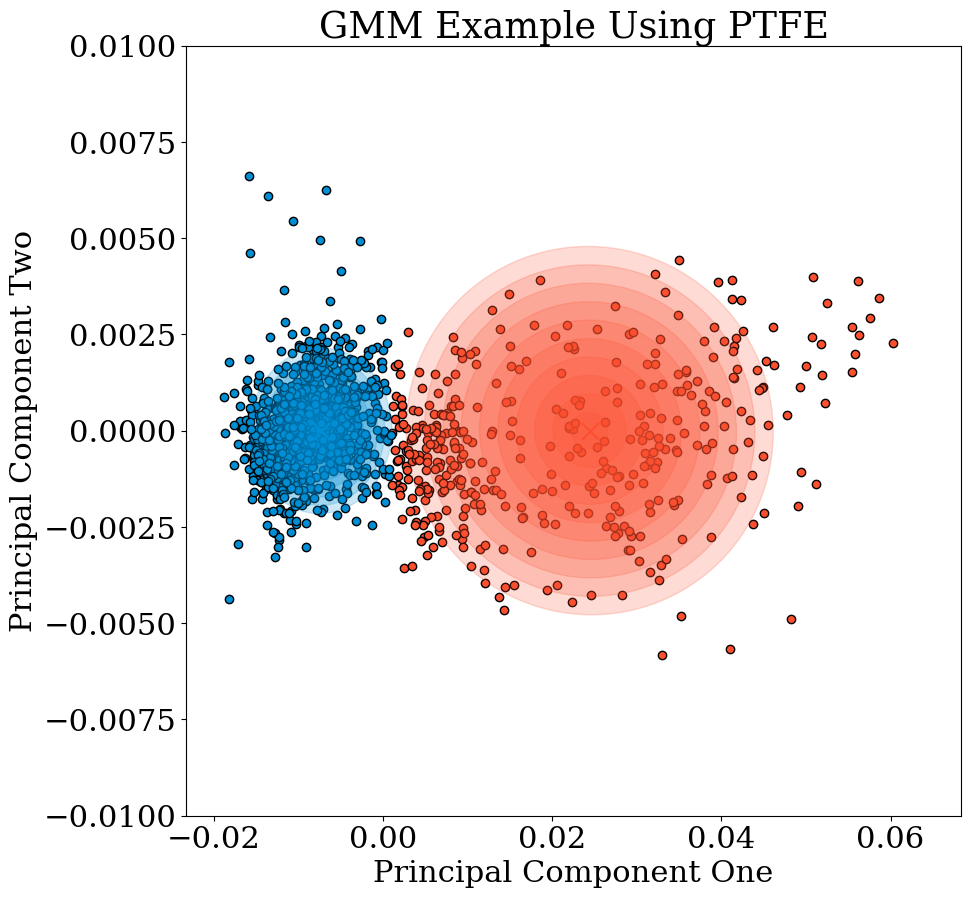

In [27]:
plt.style.use('default')

font = {'family' : 'serif',
        'size'   : 22}

plt.rc('font', **font)

I = I_gmm()
arrowsU,arrowV = I.iterative_gmm(dataset='ptfe',savegif=True,title='01_good_run',
                binary=True,mode='bgmm',nc = 2,v_and_1=False,
                n_components=2,maxiter=1,thresh=0.8,ra = True)
plt.savefig(images_dir+'GMM.png',dpi=150)

In [41]:
import os, shutil
import itertools
import imageio

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
from scipy import linalg

from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.decomposition import NMF, FastICA, PCA
from sklearn.metrics import homogeneity_score,homogeneity_completeness_v_measure
from sklearn import mixture
from skimage.restoration import inpaint
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans


import scipy.ndimage as ndimage
import scipy.spatial as spatial
import scipy.misc as misc
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, Ellipse

class I_gmm:
    def __init__(self):
        self.XY = None
        
    def plot_cov(self,means, covariances,ct):
        if ct == 'spherical':
            return
        color_iter = itertools.cycle([
                                  '#008fd5','#fc4f30'])
        ax =plt.gca()
        for i, (mean, covar, color) in enumerate(zip(
                means, covariances, color_iter)):
                
            v, w = linalg.eigh(covar)
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])
            
            v[0] = 0.015
            v[1] = 0.015

            # Plot an ellipse to show the Gaussian component
            angle = np.arctan(u[1] / u[0])
            angle = 180. * angle / np.pi  # convert to degrees
            alpha = 0.2
            
            for kk in range(0,10):
                ell = Ellipse(mean, v[0]*0.1*(kk+1), v[1]*0.1*(kk+1), 180. + angle, color=color)
                ell.set_clip_box(ax.bbox)
                ell.set_alpha(alpha)
                ax.add_artist(ell)        
            
#             multi_normal = multivariate_normal(mean[0:2],u[0:2])
#             ax.contour(np.sort(X[:,0]),np.sort(X[:,1]),
#                    multi_normal.pdf(self.XY).reshape(X.shape[0],X.shape[0]),
#                    colors='black',alpha=0.3)
            ax.scatter(mean[0],mean[1],marker='x',c=color,zorder=10,s=150)        
        
    def iterative_gmm(self,dataset = 'bb',fake = True,mode = 'gmm',binary = False,im_dir = './images/',savegif = False,title ='temp',bic_thresh = 0,maxiter = 40,nc =5,v_and_1 = False,thresh = 0.9,cov=[],n_components=2,covt='spherical',ra=False,pca = True):

        '''
        dataset: string
        The filename of the material something like 'bb','pp'
        fake: bool
        Whether or not the data is fake, if it is not it will be cropped
        mode: str
        'fraction' will reduce the input to a combination of the relative signals
        e.g. bin1 - bin0/sum
        binary: bool
        Whether or not to show the output as binary or not
        nc: int
        pca components
        '''
        np.random.seed(10)
        # Clear the imagedir
        if savegif:
            folder = im_dir
            for the_file in os.listdir(folder):
                file_path = os.path.join(folder, the_file)
                try:
                    if os.path.isfile(file_path):
                        os.unlink(file_path)
                    #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                except Exception as e:
                    print(e)
        if ra:
            arrowsU = []
            arrowsV = []        
        bic0 = np.infty
        itern = 0
        inds = [2,3,4]
        label_true = loadmat('2'+dataset+'_mask')['BW'] 
        X1 = loadmat('all'+dataset)['Z'][:,inds]

        if not fake:
            X1 = X1[400:,:].copy()
            label_true = label_true[400:].copy()
            length = 48
        else:
            length = 68

        # This is code for just looking at the ratio of the bins
        if mode == 'fraction':
            # initialize vector for fraction
            X2 = np.zeros([X1.shape[0],int(scipy.special.comb(5,2))])
            result = [x for x in itertools.combinations(np.arange(5),2)]
            for jj in range(0,X2.shape[1]):
                r2 = np.reshape(abs(X1[:,result[jj][0]] - X1[:,result[jj][1]])/abs(X1[:,result[jj][0]] + X1[:,result[jj][1]]), (20,length), order="F")
                X2[:,jj] = np.reshape(gaussian_filter1d(r2,sigma=1),20*length,order="F")
            ind = np.argsort(np.mean(X1,0))
        #     X1 = X2[:,ind[:4]]
        else:
            for jj in range(0,X1.shape[1]):
                r2 = np.reshape(X1[:,jj], (20,length), order="F")
                X1[:,jj] = np.reshape(gaussian_filter1d(r2,sigma=1),20*length,order="F")
        ct = 'full'
        if mode == 'bgmm':
            bgmm = mixture.BayesianGaussianMixture(
                    n_components=n_components, covariance_type=covt)
        elif mode == 'kmeans':
            km = KMeans(n_clusters=n_components)
        
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=covt)
        gmm1 = mixture.GaussianMixture(n_components=n_components,
                                  covariance_type='full')

        ims = []
        
        pca = True
        # Do the PCA decomposition
        if pca:
            X1 = PCA(n_components=nc).fit_transform(X1)
        
        X3 = X1[:,0:2].copy()
        
        fig = plt.figure(figsize=(10,10))
        bics = []        
        for ii in range(0,maxiter):

            X = X1.copy()

            if mode == 'gmm':
                y_pred = gmm.fit_predict(X)
            elif mode == 'bgmm':
                y_pred = bgmm.fit_predict(X)
                y_ff = gmm.fit(X)
            elif mode == 'kmeans':
                y_pred = km.fit_predict(X)
                y_ff = gmm.fit(X)
                
            
            y_ff1 = gmm1.fit(X)
            
            # if I should show the vmeasure
            if v_and_1:

                homo1,comp1,vs1 = homogeneity_completeness_v_measure(
                    label_true.squeeze(), y_pred)

                bic = gmm.aic(X)
                bic1 = gmm1.aic(X)
                print(vs1,itern,bic,bic1)
            else:
                bic = gmm.aic(X)
                print(bic)

            # Stop if bic is lower
            if bic - bic0 < bic_thresh:
                bic0 = bic
            else:
                print('BIC got higher')
                break                
            print(bic)
            
            # map the bad values to zero
            for kk in range(n_components):
                temp = X[y_pred == kk,:]

                if cov == 'robust':
                    robust_cov = MinCovDet().fit(temp)
                else:
                    robust_cov = EmpiricalCovariance().fit(temp)
                
                # Calculating the mahal distances
                robust_mahal = robust_cov.mahalanobis(
                    temp - robust_cov.location_) ** (0.33)
                
                if thresh < 1:
                    temp[robust_mahal > robust_mahal.max()*thresh] = 0
                else:
#                     import pdb; pdb.set_trace()
                    temp[robust_mahal > np.sort(robust_mahal)[-thresh]] = 0
                    
                X[y_pred == kk,:] = temp

            mask_one = X[:,1] == 0

            if y_pred[3] == 0:
                # Map top to zero if it is the wrong combo
                y_pred = y_pred + 1
                y_pred[y_pred == n_components] = 0

            m_reshape = np.reshape(mask_one, (20,length), order="F")

            if itern == 0:
                y_0 = y_pred
            
            # Plotting functions

            ax0 = fig.add_subplot(111)

            a = -(y_pred - label_true.squeeze())
            y_reshape = np.reshape(a, (20,length), order="F")
            
            colorz = ['#fc4f30','#008fd5']

            for ii,cc in zip(range(0,2),colorz):
                temp = X1[y_pred == ii,:]
                ax0.scatter(temp[:,0],temp[:,1],c=cc,edgecolor='k')

            ax0.set_title('New Method')
            self.plot_cov(km.cluster_centers_, gmm1.covariances_,ct='full')
            plt.xlabel('Principal Component One')
            plt.ylabel('Principal Component Two')
            plt.ylim([-0.01,0.01])
            plt.title('K-Means Example Using PTFE')
            plt.legend(['PTFE','PMMA'])
            

#             if itern == 0:
#                 axes = plt.gca()
#                 ylim = axes.get_ylim()
#                 xlim = axes.get_xlim() 

#             ax0.set_xlim(xlim)
#             ax0.set_ylim(ylim)
            
#             ax0.scatter(X3[:,0],X3[:,1],c='k',alpha = 0.1)

        if ra:
            return arrowsU,arrowsV
    def find_paws(self,data, smooth_radius = 1, threshold = 0.0001):
        # https://stackoverflow.com/questions/4087919/how-can-i-improve-my-paw-detection
        """Detects and isolates contiguous regions in the input array"""
        # Blur the input data a bit so the paws have a continous footprint 
        data = ndimage.uniform_filter(data, smooth_radius)
        # Threshold the blurred data (this needs to be a bit > 0 due to the blur)
        thresh = data > threshold
        # Fill any interior holes in the paws to get cleaner regions...
        filled = ndimage.morphology.binary_fill_holes(thresh)
        # Label each contiguous paw
        coded_paws, num_paws = ndimage.label(filled)
        # Isolate the extent of each paw
        # find_objects returns a list of 2-tuples: (slice(...), slice(...))
        # which represents a rectangular box around the object
        data_slices = ndimage.find_objects(coded_paws)
        return data_slices

    def animate(self,frame,im = None):
        """Detects paws and animates the position and raw data of each frame
        in the input file"""
        # With matplotlib, it's much, much faster to just update the properties
        # of a display object than it is to create a new one, so we'll just update
        # the data and position of the same objects throughout this animation...

        # Since we're making an animation with matplotlib, we need 
        # ion() instead of show()...
        fig = plt.gcf()
        ax = plt.axes([.25, .55, .6, .4], facecolor='y')
        plt.axis('off')

        # Make an image based on the first frame that we'll update later
        # (The first frame is never actually displayed)
        if im is None:
            plt.imshow(frame,cmap='brg')
        else:
            plt.imshow(im)
        plt.title('Image Space')

        # Make 4 rectangles that we can later move to the position of each paw
        rects = [Rectangle((0,0), 1,1, fc='none', ec='red') for i in range(4)]
        [ax.add_patch(rect) for rect in rects]


        # Process and display each frame

        paw_slices = self.find_paws(frame)

        # Hide any rectangles that might be visible
        [rect.set_visible(False) for rect in rects]

        # Set the position and size of a rectangle for each paw and display it
        for slice, rect in zip(paw_slices, rects):
            dy, dx = slice
            rect.set_xy((dx.start, dy.start))
            rect.set_width(dx.stop - dx.start + 1)
            rect.set_height(dy.stop - dy.start + 1)
            rect.set_visible(True)


-20060.133292560546
-20060.133292560546


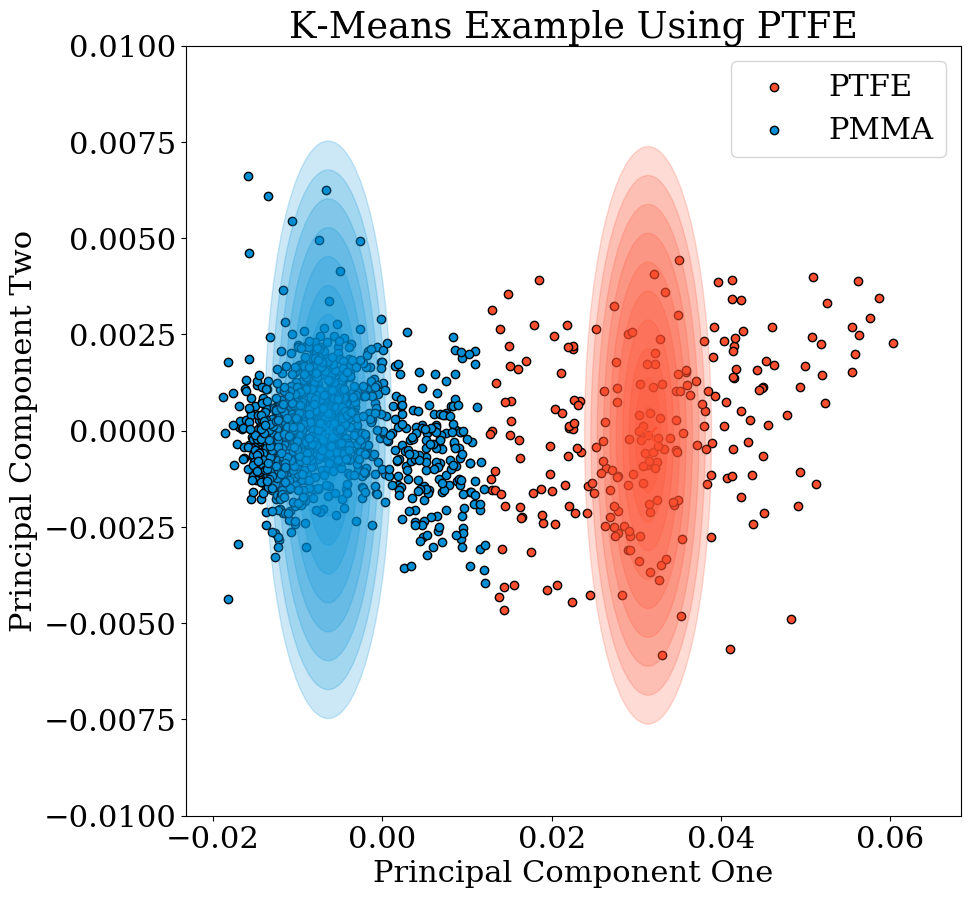

In [42]:
font = {'family' : 'serif',
        'size'   : 22}

plt.rc('font', **font)

I = I_gmm()
arrowsU,arrowV = I.iterative_gmm(dataset='ptfe',savegif=True,title='01_good_run',
                binary=True,mode='kmeans',nc = 2,v_and_1=False,
                n_components=2,maxiter=1,thresh=0.8,ra = True)
plt.savefig(images_dir+'Kmeans.png',dpi=150)

In [100]:
X = []
X.append(FastICA(n_components=2).fit_transform(M))
X.append(PCA(n_components=2).fit_transform(M))
X.append(NMF(n_components=2).fit_transform(M))

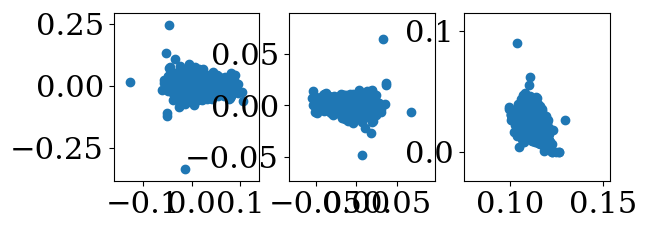

In [101]:
plt.figure()

for ii in range(0,3):
    plt.subplot(2,3,ii+1)
    plt.scatter(X[ii][:,0],X[ii][:,1])

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Miniconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm', 'mat', 'linalg']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [177]:
images_dir = '../../clustering_figures/'
#plt.style.use('default')
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
mat = 'bb'
M = loadmat('all'+mat+'.mat')['Z'][:,:]

np.random.seed(7789) #999

X = []
X.append(FastICA(n_components=2).fit_transform(M))
X.append(PCA(n_components=2).fit_transform(M))
X.append(NMF(n_components=2).fit_transform(M))

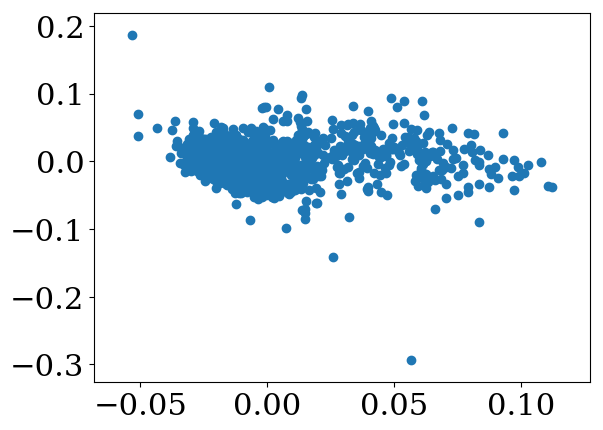

In [121]:
plt.figure()
plt.scatter(X[0][:,0],X[0][:,1])

In [122]:
# X[0] = scaler.fit_transform(X[0])
# X[1] = scaler.fit_transform(X[1])
# X[2] = scaler.fit_transform(X[2])

In [123]:
# theta = np.pi/4
# rotmat = np.asarray([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])

# X[2] = np.matmul(X[2],rotmat)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


[0.00036227 0.00112502]
1142


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


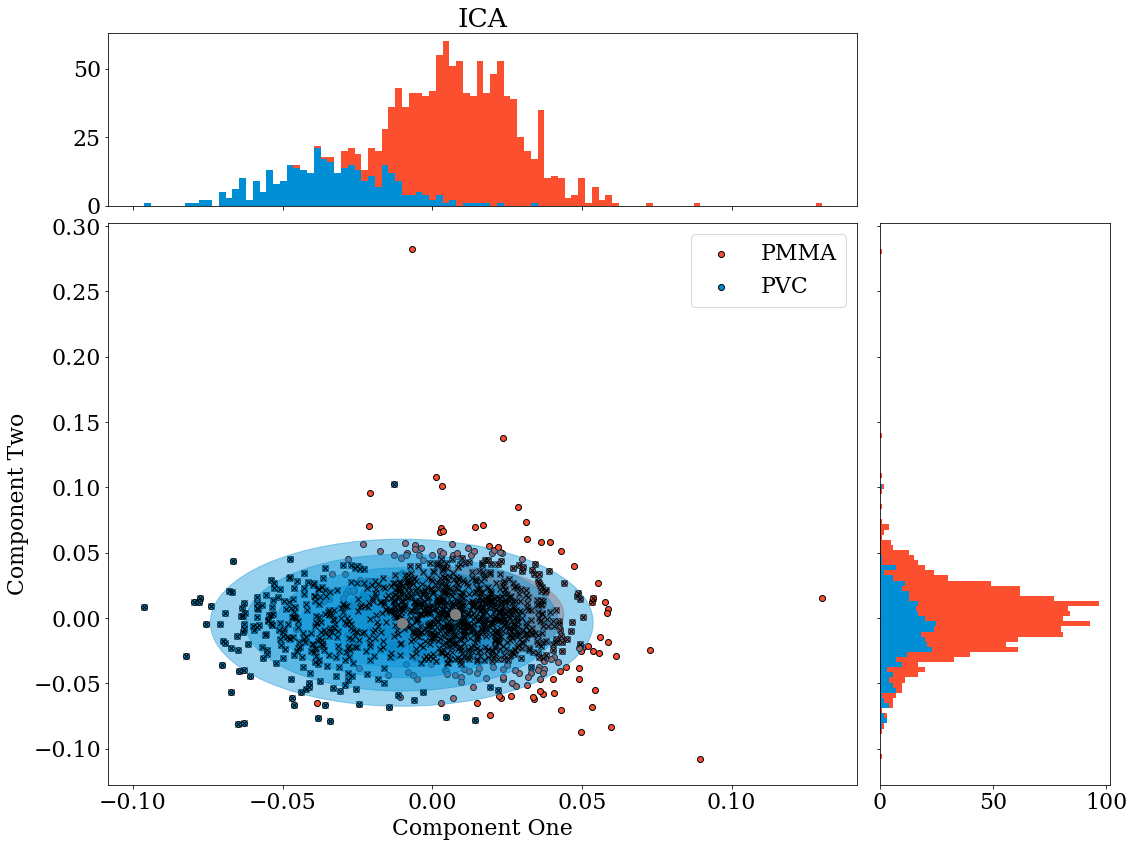

[4.99133585e-05 4.46387535e-05]
100


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


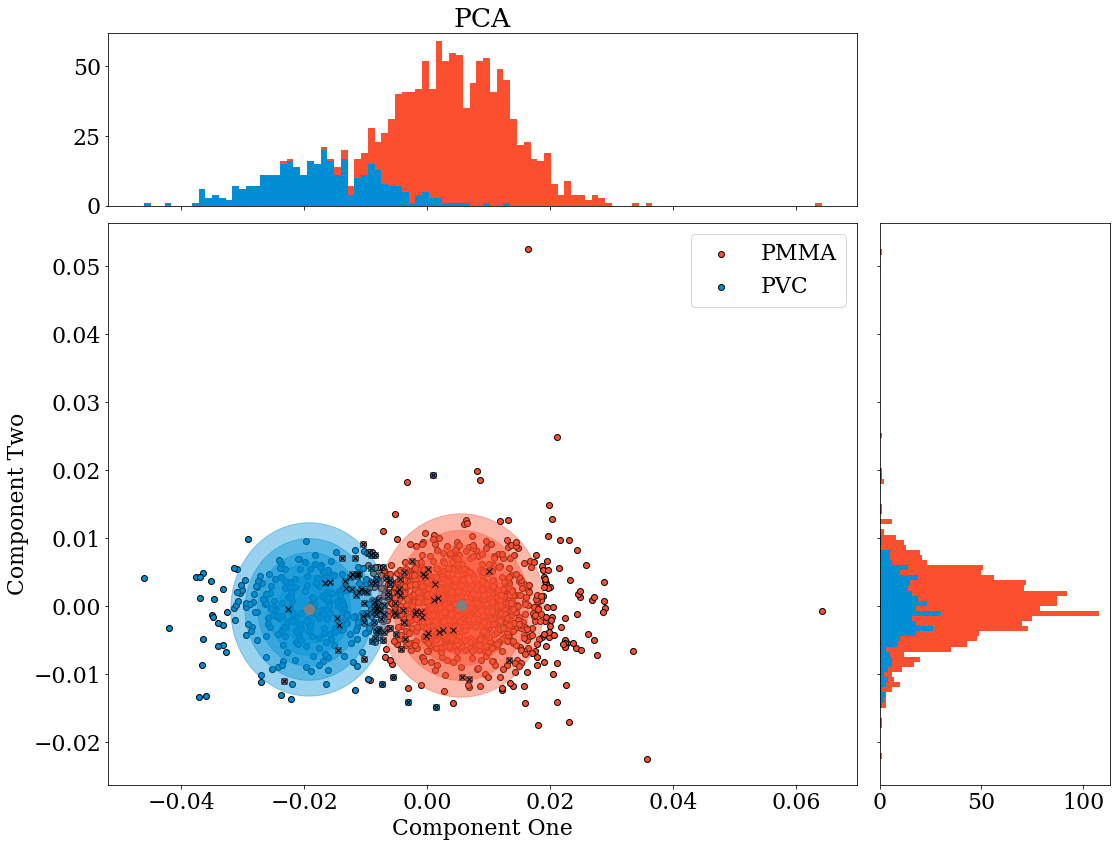

[2.55278957e-05 2.14784284e-05]
775


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


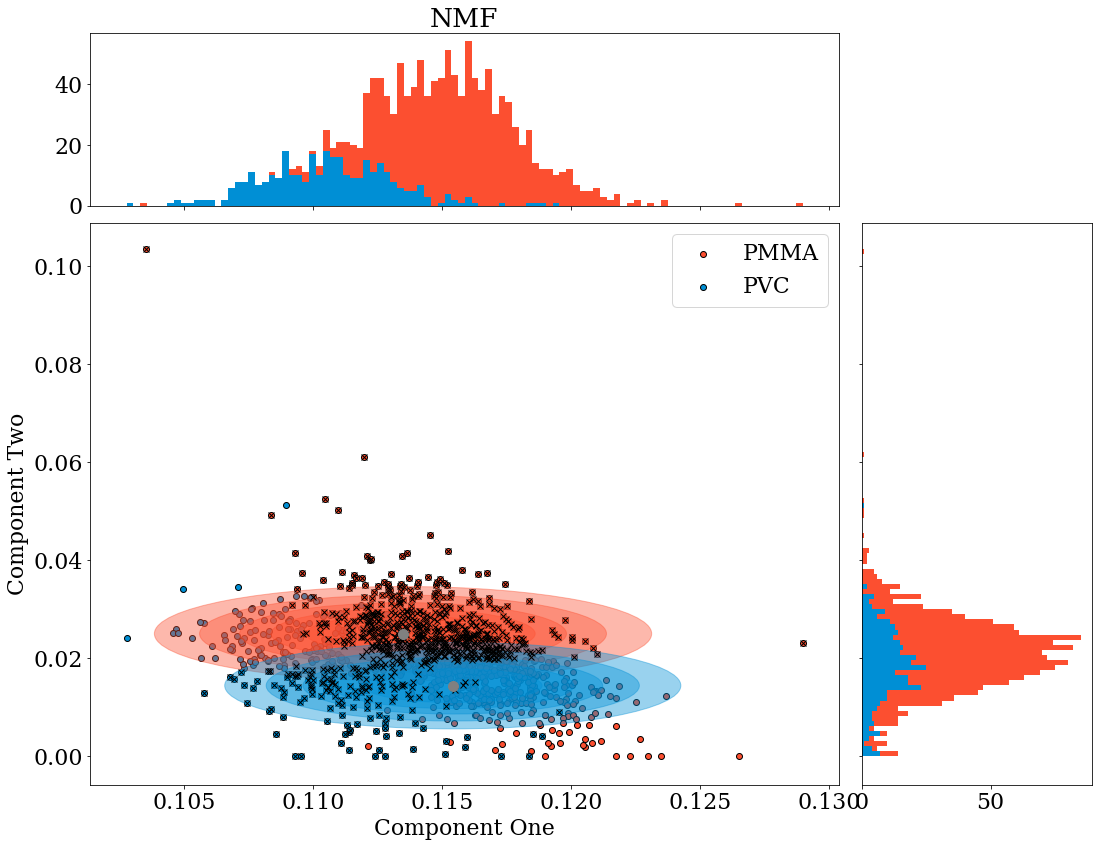

<Figure size 432x288 with 0 Axes>

In [182]:
labels_true = loadmat('2'+mat+'_mask.mat')['BW']
lab = np.reshape(labels_true, (20*68), order="F")

font = {'family' : 'serif',
        'size'   : 22}

plt.rc('font', **font)


ttls = ['ICA','PCA','NMF']
cmaps = ['BuPu','Purples','Blues','Greens','Oranges','Reds']
ebins = ['16-33 keV','33-41 keV','41-50 keV','50-64 keV','64-81 keV','81-120 keV']
# plt.figure(figsize=[7.4*2,1.85*2])
cs = []
method = 'full'
np.random.seed(999) #999

for ii,cm in zip(range(0,3),cmaps):
    
#     plt.subplot(2,3,ii+1)
#     plt.title(ebins[5 - ii])
#     plt.scatter(X[ii][:,0],X[ii][:,1])
#     plt.axis('off')
    plot_hists(X[ii][:,0],X[ii][:,1],X[ii],ii+1,lab,ttls[ii])
#     if ii == 5:
#         plt.ylim([0,150])
#         plt.xlim([0.16,0.24])        
#         plt.ylabel('count')
#     else:
#         plt.ylim([0,150])
#         plt.xlim([0.16,0.24])
#         plt.yticks([])
#     plt.xlabel(r'$ln(\frac{I}{I_0})$')
    
plt.tight_layout()

In [183]:
import scipy.ndimage as ndimage
import scipy.spatial as spatial
import scipy.misc as misc
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, Ellipse
from scipy import linalg
from matplotlib.ticker import NullFormatter


def plot_hists(x,y,X,n,lab,ttl,load_file=False):

    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

#     # start with a rectangular Figure
    plt.figure(figsize=(16,12))

    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    axHistx.set_title(ttl)
    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    
    colorz = ['#fc4f30','#008fd5']
    lbls = ['PMMA','PVC']
    
    ct = 'spherical'
    
    gmm = mixture.BayesianGaussianMixture(n_components=2,
                                      covariance_type=ct)
    
    y_pred = gmm.fit_predict(X)
    
    plot_cov(gmm.means_, gmm.covariances_,axScatter,ct=ct)
    
    # the scatter plot:
    for ii,cc in zip([0,1],colorz):
        axScatter.scatter(x[lab == ii], y[lab == ii],c=cc,edgecolor='k',label=lbls[ii])
    axScatter.set_xlabel('Component One')
    axScatter.set_ylabel('Component Two')
    axScatter.legend()
    # I think this is for the before and after with the igmm
#     ymin,ymax,xmin,xmax = -0.026178589391513553, 0.05626006209286529, -0.051897034978536274, 0.06984772768244799,

    
#     axScatter.set_ylim(ymin,ymax)
#     axScatter.set_ylim(xmin,xmax)  
    
    if y_pred[3] == 0:
        # Map top to zero if it is the wrong combo
        y_pred = y_pred + 1
        y_pred[y_pred == 2] = 0
        
    a = -(y_pred - lab)

    axScatter.plot(x[a == 0], y[a == 0],'kx')
    print(sum(a == 0))
        
    
    # now determine nice limits by hand:
    binwidth = 0.01
#     xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
#     lim = (int(xymax/binwidth) + 1) * binwidth

#     axScatter.set_xlim((-lim, lim))
#     axScatter.set_ylim((-lim, lim))

#     bins = np.arange(-lim, lim + binwidth, binwidth)

    b0 = axHistx.hist(x,bins=100,color='#fc4f30')[1]
    b1 = axHisty.hist(y,bins=100, orientation='horizontal',color='#fc4f30')[1]
    
    axHistx.hist(x[lab == ii],b0,color='#008fd5')
    axHisty.hist(y[lab == ii],b1,color='#008fd5', orientation='horizontal')
    
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    images_dir = '../../clustering_figures/'
    
    plt.tight_layout()

    plt.savefig((images_dir+ttl+'sphericalafter'+'.png'),dpi=150,format='png') # 'test' replace with ct
    plt.show()

    

In [ ]:
theta = np.pi/4
rotmat = np.asarray([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])

X[2] = np.matmul(X[2],rotmat)

In [46]:
import itertools
from scipy import linalg

def plot_cov(means, covariances,ax,ct = 'full'):

    color_iter = itertools.cycle(['#fc4f30','#008fd5'])
    print(covariances)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        
        if ct == 'spherical':
            covar2 = [[covar,-covar],[-covar,covar]]
            v, w = linalg.eigh(covar2)
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])
            v[0] = v[1]
        else:
            v, w = linalg.eigh(covar)
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])

#         v[0] = 0.015
#         v[1] = 0.015

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        alpha = 0.4
        
        nums = [0.56,0.76,.94,1.17,1.43]
        
        for kk in range(0,len(nums)):
            ell = Ellipse(mean, v[0]*nums[kk]/1.5, v[1]*nums[kk]/1.5, 180. + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(alpha)
            ax.add_artist(ell)   

#             multi_normal = multivariate_normal(mean[0:2],u[0:2])
#             ax.contour(np.sort(X[:,0]),np.sort(X[:,1]),
#                    multi_normal.pdf(self.XY).reshape(X.shape[0],X.shape[0]),
#                    colors='black',alpha=0.3)
        ax.scatter(mean[0],mean[1],c='grey',zorder=10,s=100)   

In [140]:
def compare_2(bars_se,bars_pc,title='all',leg=['Single Energy','Spectral'],algo=True):
    cinds=[0,2,3,4,7,8,9,10]

    ms = []
    two_means = []
    ward =[]
    spectral = []
    dbscan = []
    average_linkage = []
    affinity_propagation = []
    birch = []
    gmm = []
    bgmm = []
    hdb = []

    cinds_all = (
        ('KMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('HDBSCAN', hdb),
        ('GaussianMixture', gmm),
        ('BGaussianMixture', bgmm)
    )
    plt.figure()
    clustering_algorithms = [cinds_all[j] for j in cinds]
    
    if algo:
        
        bars_se2 = np.mean(np.asarray(bars_se),axis=0)
        bars_pc2 = np.mean(np.asarray(bars_pc),axis=0)

        indeces = np.argsort(bars_pc2)

        bars_se2 = bars_se2[indeces]

        bars_pc2.sort()
    else:
        bars_se2 = np.asarray(bars_se)
        bars_pc2 = np.asarray(bars_pc)     

    # vs = np.asarray(vs)
    bars = []
    colors = []
    n_components_range = range(len(bars_pc2))
    # cv_types = [item[1] for item in datasets2]


    # color_iter = cycle(['navy', 'turquoise', 'cornflowerblue',
    #                               'darkorange','k'])
    # # Plot the BIC scores
    # plt.figure(figsize=(8, 6))
    # plt.rcParams['axes.facecolor'] = (1,1,1)            
    # spl = plt.subplot(1, 1, 1)

    # for i, (cv_type, pcolor) in enumerate(zip(cv_types, color_iter)):
    #     xpos = np.array(n_components_range) + 0.166 * (i - 2)
    #     bars.append( vs[i * len(n_components_range):
    #                                   (i + 1) * len(n_components_range)])

    # # import ipdb; ipdb.set_trace()
    [colors.append(colourblind(col)) for col in n_components_range]

    # bars2 = np.mean(np.asarray(bars),axis=0)

    # indeces = np.argsort(bars2)
    # #         import ipdb; ipdb.set_trace()
    # bars2.sort()
    # bars2 = np.concatenate(bars_se2,bars_de2,bars_pc2)
    datasets2 = (('glass','Glass'),('pp','Poly'),('bb','Bluebelt'),('ptfe','PTFE'),('steel','Steel'
            ),('PMMA','PMMA'))
    
    if algo:
        clustering_algorithms = [clustering_algorithms[i] for i in indeces]
    

    plt.bar(range(1,len(bars_pc2)*3,3),bars_se2,color='#008fd5')
    plt.bar(range(2,len(bars_pc2)*3,3),bars_pc2,color='#fc4f30')
    if algo:
        plt.xticks(range(1,len(bars_pc2)*3,3),[item[0] for item in clustering_algorithms],rotation = 45, ha="right")
        plt.xlabel('Algorithm')
        plt.ylabel('V-score')
    else:
        plt.xticks(range(1,len(bars_pc2)*3,3),[item[1] for item in datasets2],rotation = 45, ha="right")
        plt.xlabel('Material')
        plt.ylabel('Weight of Component')        
    plt.xticks()
    if algo:
        plt.ylim([0, 1])
    plt.title('Mixture Weights for Two Components')
    # xpos = np.mod(vs.argmax(), len(n_components_range)) + .65 +\
    #     .16 * np.floor(vs.argmax() / len(n_components_range))
    # plt.text(xpos, vs.min() * 0.97 + .03 * vs.max(), '*', fontsize=14)

    plt.legend(leg,loc=1)  
    plt.tight_layout()
    images_dir = '../../clustering_figures/'
    plt.savefig(images_dir + '{}.png'.format(title),dpi=300)

In [141]:
aic_2 = plot_results(0,0,0,1,cinds=[10],dinds=[0,1,2,3,4,5],return_weights=True,out=False,rng=4508)

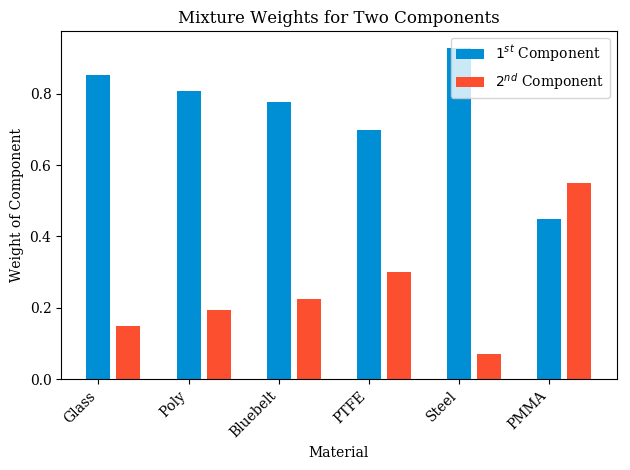

In [142]:

plt.style.use('default')

font = {'family' : 'serif'}

plt.rc('font', **font)

weight_0 = np.asarray(aic_2)[:,0]
weight_1 = np.asarray(aic_2)[:,1]
compare_2(weight_0,weight_1,title='weights',leg=['$1^{st}$ Component','$2^{nd}$ Component'],algo=False)

In [143]:
aic_2 = plot_results(0,0,0,1,cinds=[9],dinds=[0,1,2,3,4,5],return_AIC=True,out=False,algo_params={})
aic_1 = plot_results(0,0,0,1,cinds=[9],dinds=[0,1,2,3,4,5],algo_params={'n_clusters': 1},return_AIC=True,out=False)

In [144]:
def compare_2(bars_se,bars_pc,title='all',leg=['Single Energy','Spectral'],algo=True):
    cinds=[0,2,3,4,7,8,9,10]

    ms = []
    two_means = []
    ward =[]
    spectral = []
    dbscan = []
    average_linkage = []
    affinity_propagation = []
    birch = []
    gmm = []
    bgmm = []
    hdb = []

    cinds_all = (
        ('KMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('HDBSCAN', hdb),
        ('GaussianMixture', gmm),
        ('BGaussianMixture', bgmm)
    )
    plt.figure()
    clustering_algorithms = [cinds_all[j] for j in cinds]
    
    if algo:
        
        bars_se2 = np.mean(np.asarray(bars_se),axis=0)
        bars_pc2 = np.mean(np.asarray(bars_pc),axis=0)

        indeces = np.argsort(bars_pc2)

        bars_se2 = bars_se2[indeces]

        bars_pc2.sort()
    else:
        bars_se2 = np.asarray(bars_se)
        bars_pc2 = np.asarray(bars_pc)     

    # vs = np.asarray(vs)
    bars = []
    colors = []
    n_components_range = range(len(bars_pc2))
    # cv_types = [item[1] for item in datasets2]


    # color_iter = cycle(['navy', 'turquoise', 'cornflowerblue',
    #                               'darkorange','k'])
    # # Plot the BIC scores
    # plt.figure(figsize=(8, 6))
    # plt.rcParams['axes.facecolor'] = (1,1,1)            
    # spl = plt.subplot(1, 1, 1)

    # for i, (cv_type, pcolor) in enumerate(zip(cv_types, color_iter)):
    #     xpos = np.array(n_components_range) + 0.166 * (i - 2)
    #     bars.append( vs[i * len(n_components_range):
    #                                   (i + 1) * len(n_components_range)])

    # # import ipdb; ipdb.set_trace()
    [colors.append(colourblind(col)) for col in n_components_range]

    # bars2 = np.mean(np.asarray(bars),axis=0)

    # indeces = np.argsort(bars2)
    # #         import ipdb; ipdb.set_trace()
    # bars2.sort()
    # bars2 = np.concatenate(bars_se2,bars_de2,bars_pc2)
    datasets2 = (('glass','Glass'),('pp','Poly'),('bb','Bluebelt'),('ptfe','PTFE'),('steel','Steel'
            ),('PMMA','PMMA'))
    
    if algo:
        clustering_algorithms = [clustering_algorithms[i] for i in indeces]
    

    plt.bar(range(1,len(bars_pc2)*3,3),bars_se2,color='#008fd5')
    plt.bar(range(2,len(bars_pc2)*3,3),bars_pc2,color='#fc4f30')
    if algo:
        plt.xticks(range(1,len(bars_pc2)*3,3),[item[0] for item in clustering_algorithms],rotation = 45, ha="right")
        plt.xlabel('Algorithm')
        plt.ylabel('V-score')
    else:
        plt.xticks(range(1,len(bars_pc2)*3,3),[item[1] for item in datasets2],rotation = 45, ha="right")
        plt.xlabel('Material')
        plt.ylabel('AIC')        
    plt.xticks()
    if algo:
        plt.ylim([0, 1])
    plt.title(title)
    # xpos = np.mod(vs.argmax(), len(n_components_range)) + .65 +\
    #     .16 * np.floor(vs.argmax() / len(n_components_range))
    # plt.text(xpos, vs.min() * 0.97 + .03 * vs.max(), '*', fontsize=14)

    plt.legend(leg,loc=1)  
    plt.tight_layout()
    images_dir = '../../clustering_figures/'
    plt.savefig(images_dir + '{}.png'.format(title),dpi=300)

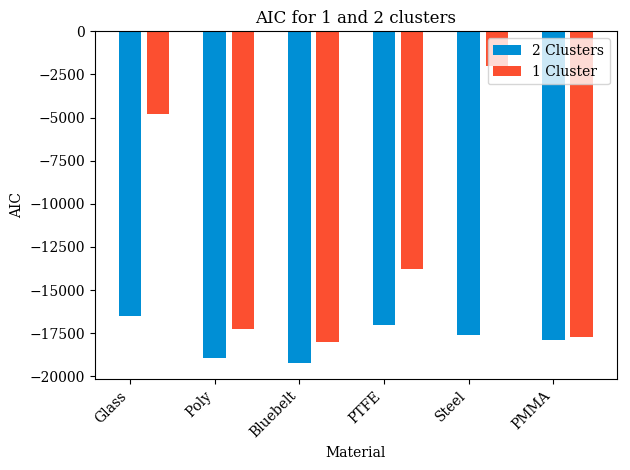

In [145]:
compare_2(aic_2,aic_1,title='AIC for 1 and 2 clusters',leg=['2 Clusters','1 Cluster'],algo=False)

FigureCanvasNbAgg()

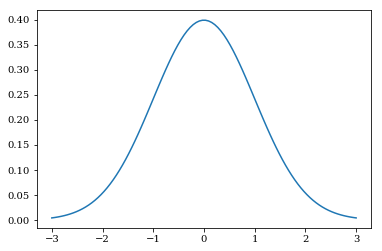

In [146]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [147]:
0.56,0.76,.94,1.17,1.43

(0.56, 0.76, 0.94, 1.17, 1.43)

In [148]:
import os, shutil
import itertools
import imageio

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
from scipy import linalg

from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.decomposition import NMF, FastICA, PCA
from sklearn.metrics import homogeneity_score,homogeneity_completeness_v_measure
from sklearn import mixture
from skimage.restoration import inpaint
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans


import scipy.ndimage as ndimage
import scipy.spatial as spatial
import scipy.misc as misc
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, Ellipse

class I_gmm:
    def __init__(self):
        self.XY = None
        
    def plot_cov(self,means, covariances,ct):
        if ct == 'spherical':
            return
        color_iter = itertools.cycle(['navy', 'navy', 'cornflowerblue', 'gold',
                                  'darkorange'])
        ax =plt.gca()
        for i, (mean, covar, color) in enumerate(zip(
                means, covariances, color_iter)):
                
            v, w = linalg.eigh(covar)
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])

            # Plot an ellipse to show the Gaussian component
            angle = np.arctan(u[1] / u[0])
            angle = 180. * angle / np.pi  # convert to degrees
            alpha = 0.2
            ell = Ellipse(mean, v[0], v[1], 180. + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(alpha)
            ax.add_artist(ell)
            ell = Ellipse(mean, v[0]*4, v[1]*2, 180. + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(alpha)
            ell = Ellipse(mean, v[0]*2, v[1]*2, 180. + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(alpha)
            ax.add_artist(ell)            
#             multi_normal = multivariate_normal(mean[0:2],u[0:2])
#             ax.contour(np.sort(X[:,0]),np.sort(X[:,1]),
#                    multi_normal.pdf(self.XY).reshape(X.shape[0],X.shape[0]),
#                    colors='black',alpha=0.3)
            ax.scatter(mean[0],mean[1],c='grey',zorder=10,s=100)        
        
    def iterative_gmm(self,dataset = 'bb',fake = True,mode = 'gmm',binary = False,im_dir = './images/',savegif = False,title ='temp',bic_thresh = 0,maxiter = 40,nc =5,v_and_1 = False,thresh = 0.9,cov=[],n_components=2,covt='spherical',ra=False,pca = True):

        '''
        dataset: string
        The filename of the material something like 'bb','pp'
        fake: bool
        Whether or not the data is fake, if it is not it will be cropped
        mode: str
        'fraction' will reduce the input to a combination of the relative signals
        e.g. bin1 - bin0/sum
        binary: bool
        Whether or not to show the output as binary or not
        nc: int
        pca components
        '''
        # Clear the imagedir
        if savegif:
            folder = im_dir
            for the_file in os.listdir(folder):
                file_path = os.path.join(folder, the_file)
                try:
                    if os.path.isfile(file_path):
                        os.unlink(file_path)
                    #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                except Exception as e:
                    print(e)
        if ra:
            arrowsU = []
            arrowsV = []        
        bic0 = np.infty
        itern = 0
        inds = [2,3,4]
        label_true = loadmat('2'+dataset+'_mask')['BW'] 
        X1 = loadmat('all'+dataset)['Z'][:,inds]

        if not fake:
            X1 = X1[400:,:].copy()
            label_true = label_true[400:].copy()
            length = 48
        else:
            length = 68

        # This is code for just looking at the ratio of the bins
        if mode == 'fraction':
            # initialize vector for fraction
            X2 = np.zeros([X1.shape[0],int(scipy.special.comb(5,2))])
            result = [x for x in itertools.combinations(np.arange(5),2)]
            for jj in range(0,X2.shape[1]):
                r2 = np.reshape(abs(X1[:,result[jj][0]] - X1[:,result[jj][1]])/abs(X1[:,result[jj][0]] + X1[:,result[jj][1]]), (20,length), order="F")
                X2[:,jj] = np.reshape(gaussian_filter1d(r2,sigma=1),20*length,order="F")
            ind = np.argsort(np.mean(X1,0))
        #     X1 = X2[:,ind[:4]]
        else:
            for jj in range(0,X1.shape[1]):
                r2 = np.reshape(X1[:,jj], (20,length), order="F")
                X1[:,jj] = np.reshape(gaussian_filter1d(r2,sigma=1),20*length,order="F")
        ct = 'full'
        if mode == 'bgmm':
            bgmm = mixture.BayesianGaussianMixture(
                    n_components=n_components, covariance_type=covt)
        elif mode == 'kmeans':
            km = KMeans(n_clusters=n_components)
        
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=covt)
        gmm1 = mixture.GaussianMixture(n_components=n_components,
                                  covariance_type='full')

        ims = []
        
        pca = True
        # Do the PCA decomposition
        if pca:
            X1 = PCA(n_components=nc).fit_transform(X1)
        
        X3 = X1[:,0:2].copy()
        
        fig = plt.figure(figsize=(10,10))
        bics = []        
        for ii in range(0,maxiter):

            X = X1.copy()

            if mode == 'gmm':
                y_pred = gmm.fit_predict(X)
            elif mode == 'bgmm':
                y_pred = bgmm.fit_predict(X)
                y_ff = gmm.fit(X)
            elif mode == 'kmeans':
                y_pred = km.fit_predict(X)
                y_ff = gmm.fit(X)
            
            y_ff1 = gmm1.fit(X)
            
            # if I should show the vmeasure
            if v_and_1:

                homo1,comp1,vs1 = homogeneity_completeness_v_measure(
                    label_true.squeeze(), y_pred)

                bic = gmm.aic(X)
                bic1 = gmm1.aic(X)
                print(vs1,itern,bic,bic1)
            else:
                bic = gmm.aic(X)
                print(bic)

            # Stop if bic is lower
            if bic - bic0 < bic_thresh:
                bic0 = bic
            else:
                print('BIC got higher')
                break                
            print(bic)
            
            # map the bad values to zero
            for kk in range(n_components):
                temp = X[y_pred == kk,:]

                if cov == 'robust':
                    robust_cov = MinCovDet().fit(temp)
                else:
                    robust_cov = EmpiricalCovariance().fit(temp)
                
                # Calculating the mahal distances
                robust_mahal = robust_cov.mahalanobis(
                    temp - robust_cov.location_) ** (0.33)
                
                if thresh < 1:
                    temp[robust_mahal > robust_mahal.max()*thresh] = 0
                else:
#                     import pdb; pdb.set_trace()
                    temp[robust_mahal > np.sort(robust_mahal)[-thresh]] = 0
                    
                X[y_pred == kk,:] = temp

            mask_one = X[:,1] == 0

            if y_pred[3] == 0:
                # Map top to zero if it is the wrong combo
                y_pred = y_pred + 1
                y_pred[y_pred == n_components] = 0

            m_reshape = np.reshape(mask_one, (20,length), order="F")

            if itern == 0:
                y_0 = y_pred
            
            # Plotting functions

            ax0 = fig.add_subplot(111)

            a = -(y_pred - label_true.squeeze())
            y_reshape = np.reshape(a, (20,length), order="F")
            
            colorz = ['b','r','g','m']
            for jj,color in zip(range(a.min(),a.max()+1),colorz):
                print(jj)
                b = a == jj
                b = [i for i, x in enumerate(b) if x]
                if jj == 0:
                    c = b
                ax0.scatter(X1[b,0],X1[b,1],c=colorz[(jj-a.min())])

            ax0.set_title('New Method')
            self.plot_cov(gmm1.means_, gmm1.covariances_,ct='full')

            if itern == 0:
                axes = plt.gca()
                ylim = axes.get_ylim()
                xlim = axes.get_xlim() 

            ax0.set_xlim(xlim)
            ax0.set_ylim(ylim)
            
            ax0.scatter(X3[:,0],X3[:,1],c='k',alpha = 0.1)
            plt.text(.5*xlim[-1], ylim[0] + .005,'bad pts = {}'.format(format(len(c),"03")))     
            ax3 = plt.axes([.22, .15, .15, .1])
            bics.append(bic)
            plt.plot(bics)
            plt.yticks([])
            plt.xlabel('iteration')
            plt.ylabel('BIC')
            ax2 = plt.axes([.25, .55, .6, .4], facecolor='y')

            if binary:
                plt.imshow(y_reshape,cmap='brg')
            else:
                plt.imshow(np.reshape(X1[:,0], (20,length), order="F"))

            plt.title('Image Space')
            plt.xticks([])
            plt.yticks([])

            if savegif:
                plt.savefig(im_dir + '{}.png'.format(format(itern, "02")))
                
            itern += 1
            
            i, j = np.where(m_reshape == True)

#             if binary:
#                 plt.imshow(y_reshape,cmap='brg')
#             else:
            plt.scatter(j,i,marker='x',c='k')
            
#             import pdb; pdb.set_trace()
            d = [i for i, x in enumerate(mask_one) if x]
            ax0.scatter(X1[d,0],X1[d,1],marker='x',c='k')
   
                
            if savegif:
                plt.savefig(im_dir + '{}.png'.format(format(itern, "02")))
            
            itern += 1
            
            X2 = X1.copy()
            # Inpainting the zeros
            r2 = np.reshape(X1, (20,length,X1.shape[1]), order="F")
            X1 = np.reshape(inpaint.inpaint_biharmonic(
                r2,m_reshape,multichannel=True),
                            (20*length,X1.shape[1]),order="F")
            
            ax0.plot([X2[d,0],X1[d,0]],[X2[d,1],X1[d,1]],'r')
            
            if ra:
                arrowsU.append([X2[d,0],X1[d,0]])
                arrowsV.append([X2[d,1],X1[d,1]])
            
            
            if binary:
                plt.imshow(y_reshape,cmap='brg')
            else:
                plt.imshow(np.reshape(X1[:,0], (20,length), order="F"))
            
            if savegif:
                plt.savefig(im_dir + '{}.png'.format(format(itern, "02")))
                plt.clf()
            
            

    #         X_old = X.copy()
    #             np.save('bb',y_reshape)

        #     plt.figure()
        #     robust_mahal1.sort()
        #     plt.plot(robust_mahal1)
        #     plt.plot(250,robust_mahal1.max()*.87,'r*')
        #     plt.savefig('./images2/{}.png'.format(format(itern, "02")))  

        #     plt.figure()
        #     robust_mahal2.sort()
        #     plt.plot(robust_mahal2)
        #     plt.plot(250,robust_mahal2.max()*.87,'r*')
        #     plt.savefig('./images3/{}.png'.format(format(itern, "02")))  
            itern += 1

        fig = plt.figure(figsize=(10,10))
        ax0 = fig.add_subplot(111)  

        colorz = ['b','r','g','m']
        for jj,color in zip(range(a.min(),a.max()+1),colorz):
            print(jj)
            b = a == jj
            b = [i for i, x in enumerate(b) if x]
            if jj == 0:
                c = b
            ax0.scatter(X1[b,0],X1[b,1],c=colorz[(jj-a.min())])
            
        self.plot_cov(gmm1.means_, gmm1.covariances_,ct)
        ax0.scatter(X3[:,0],X3[:,1],c='k',alpha = 0.1)

        ax0.set_title('New Method')
        ax0.set_xlim(xlim)
        ax0.set_ylim(ylim)
        plt.text(.5*xlim[-1], ylim[0] + .005,'bad pts = {}'.format(format(len(c),"03")))      
        
        r = np.reshape(y_pred, (20,length), order="F")
        if binary:
            self.animate(y_reshape)
        else:
            self.animate(y_reshape, im=np.reshape(X1[:,0], (20,length), order="F"))
        ax3 = plt.axes([.22, .15, .15, .1])
        bics.append(bic)
        plt.plot(bics)
        plt.yticks([])
        plt.xlabel('iteration')
        plt.ylabel('BIC')
        plt.savefig(im_dir + '{}.png'.format(format(itern, "02")))


        plt.figure()
        plt.imshow(r)
        plt.xticks([])
        plt.yticks([])  
        plt.figure()

        r0 = np.reshape(y_0, (20,length), order="F")
        plt.imshow(r - r0)
        plt.xticks([])
        plt.yticks([])  
        
        ttls = ['ICA','PCA','NMF']
        ll = 1
        np.random.seed(999)


        plot_hists(X1[:,0],X1[:,1],X1[:,[0,1]],ll+1,lab,ttls[ll])

        if savegif:
            # save gif
            files = os.listdir('./images')
            images = []
            for filename in files:
                images.append(imageio.imread('./images/'+filename))
            imageio.mimsave(title + '.mp4', images,fps=1)
            imageio.mimsave(title + '.gif', images)


        if ra:
            return r
    def find_paws(self,data, smooth_radius = 1, threshold = 0.0001):
        # https://stackoverflow.com/questions/4087919/how-can-i-improve-my-paw-detection
        """Detects and isolates contiguous regions in the input array"""
        # Blur the input data a bit so the paws have a continous footprint 
        data = ndimage.uniform_filter(data, smooth_radius)
        # Threshold the blurred data (this needs to be a bit > 0 due to the blur)
        thresh = data > threshold
        # Fill any interior holes in the paws to get cleaner regions...
        filled = ndimage.morphology.binary_fill_holes(thresh)
        # Label each contiguous paw
        coded_paws, num_paws = ndimage.label(filled)
        # Isolate the extent of each paw
        # find_objects returns a list of 2-tuples: (slice(...), slice(...))
        # which represents a rectangular box around the object
        data_slices = ndimage.find_objects(coded_paws)
        return data_slices

    def animate(self,frame,im = None):
        """Detects paws and animates the position and raw data of each frame
        in the input file"""
        # With matplotlib, it's much, much faster to just update the properties
        # of a display object than it is to create a new one, so we'll just update
        # the data and position of the same objects throughout this animation...

        # Since we're making an animation with matplotlib, we need 
        # ion() instead of show()...
        fig = plt.gcf()
        ax = plt.axes([.21, .56, .6, .4], facecolor='y')
        plt.axis('off')

        # Make an image based on the first frame that we'll update later
        # (The first frame is never actually displayed)
        if im is None:
            plt.imshow(frame,cmap='brg')
        else:
            plt.imshow(im)
        plt.title('Image Space')

        # Make 4 rectangles that we can later move to the position of each paw
        rects = [Rectangle((0,0), 1,1, fc='none', ec='red') for i in range(4)]
        [ax.add_patch(rect) for rect in rects]


        # Process and display each frame

        paw_slices = self.find_paws(frame)

        # Hide any rectangles that might be visible
        [rect.set_visible(False) for rect in rects]

        # Set the position and size of a rectangle for each paw and display it
        for slice, rect in zip(paw_slices, rects):
            dy, dx = slice
            rect.set_xy((dx.start, dy.start))
            rect.set_width(dx.stop - dx.start + 1)
            rect.set_height(dy.stop - dy.start + 1)
            rect.set_visible(True)


In [195]:
import scipy.ndimage as ndimage
import scipy.spatial as spatial
import scipy.misc as misc
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, Ellipse
from scipy import linalg
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FormatStrFormatter



def plot_hists(x,y,X,n,lab,ttl,load_file=False):

    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

#     # start with a rectangular Figure
    plt.figure(figsize=(16,12))

    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    axHistx.set_title(ttl)
    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    
    colorz = ['#fc4f30','#008fd5']
    lbls = ['PMMA','PVC']
    
    ct = 'spherical'
    
    gmm = mixture.BayesianGaussianMixture(n_components=2,
                                      covariance_type=ct)
    
    y_pred = gmm.fit_predict(X)
    
    plot_cov(gmm.means_, gmm.covariances_,axScatter,ct=ct)
    
    # the scatter plot:
    for ii,cc in zip([0,1],colorz):
        axScatter.scatter(x[lab == ii], y[lab == ii],c=cc,edgecolor='k',label=lbls[ii])
    axScatter.set_xlabel('Component One')
    axScatter.set_ylabel('Component Two')
    axScatter.legend()
    # I think this is for the before and after with the igmm
#     ymin,ymax,xmin,xmax = -0.026178589391513553, 0.05626006209286529, -0.051897034978536274, 0.06984772768244799,

    
#     axScatter.set_ylim(ymin,ymax)
#     axScatter.set_ylim(xmin,xmax)  
    
    if y_pred[3] == 0:
        # Map top to zero if it is the wrong combo
        y_pred = y_pred + 1
        y_pred[y_pred == 2] = 0
        
    a = -(y_pred - lab)

    axScatter.plot(x[a == 0], y[a == 0],'kx')
    print(sum(a == 0))
        
    axScatter.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))    # now determine nice limits by hand:
    binwidth = 0.01
#     xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
#     lim = (int(xymax/binwidth) + 1) * binwidth

#     axScatter.set_xlim((-lim, lim))
#     axScatter.set_ylim((-lim, lim))

#     bins = np.arange(-lim, lim + binwidth, binwidth)

    b0 = axHistx.hist(x,bins=100,color='#fc4f30')[1]
    b1 = axHisty.hist(y,bins=100, orientation='horizontal',color='#fc4f30')[1]
    
    axHistx.hist(x[lab == ii],b0,color='#008fd5')
    axHisty.hist(y[lab == ii],b1,color='#008fd5', orientation='horizontal')
    
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    images_dir = '../../clustering_figures/'
    
    plt.tight_layout()

    plt.savefig((images_dir+ttl+'sphericalafter'+'.png'),dpi=150,format='png') # 'test' replace with ct
    plt.show()

In [196]:
I = I_gmm()
%matplotlib inline

0.6951181743230227 0 -35284.74759711604 -38785.4376648551
-35284.74759711604
-1
0
1
0.6953211965117359 3 -35415.43899547991 -39058.72907609859
-35415.43899547991
-1
0
1
0.6976277797795727 6 -35519.69935666893 -39354.40923644162
-35519.69935666893
-1
0
1
0.6976277797795727 9 -35543.21409297654 -39449.42317603492
-35543.21409297654
-1
0
1
0.6976277797795727 12 -35552.08900743651 -39498.45133341956
-35552.08900743651
-1
0
1
0.6976277797795727 15 -35615.59289652367 -39565.62606977775
-35615.59289652367
-1
0
1
0.6976277797795727 18 -35652.981692446774 -39675.617395392735
-35652.981692446774
-1
0
1
0.7051055422610644 21 -35682.74791743291 -39735.98156437214
-35682.74791743291
-1
0
1
0.7051055422610644 24 -35691.96342213462 -39808.326357716345
-35691.96342213462
-1
0
1
0.7232613757083637 27 -35758.21789677901 -39961.53684822045
-35758.21789677901
-1
0
1
0.7273031255279013 30 -35768.26430402635 -39977.42741957177
-35768.26430402635
-1
0
1
0.7403165544349993 33 -35782.883127028435 -39992.293910

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<Figure size 720x720 with 0 Axes>

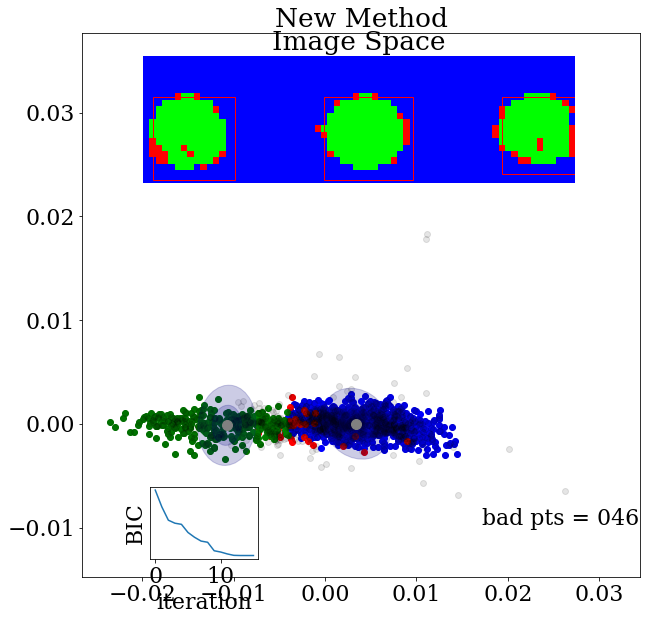

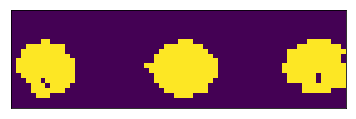

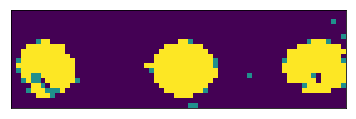

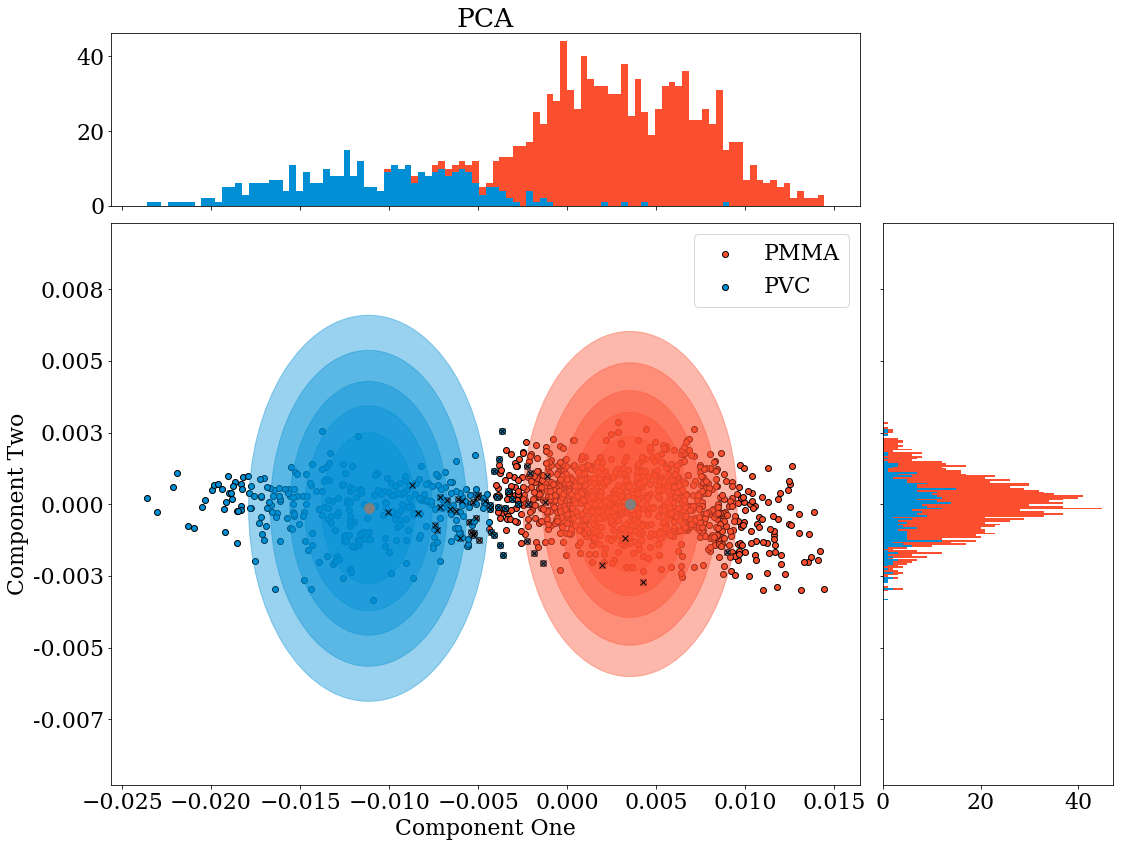

In [198]:
font = {'family' : 'serif',
        'size'   : 22}

plt.rc('font', **font)

r = I.iterative_gmm(dataset='bb',savegif=True,title='01_good_run',
                binary=True,mode='bgmm',nc = 3,v_and_1=True,
                n_components=2,maxiter=20,thresh=0.9,ra = True)

# arrowsU,arrowV = I.iterative_gmm(dataset='bb',savegif=True,title='01_good_run',
# #                 binary=True,mode='bgmm',nc = 4,v_and_1=False,
# #                 n_components=2,maxiter=20,ra = True)

ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (20,68,68)

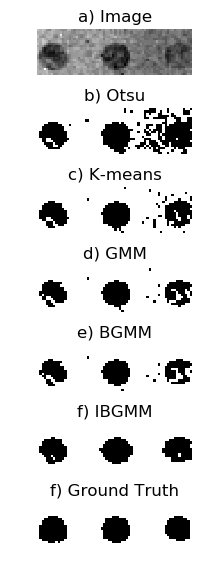

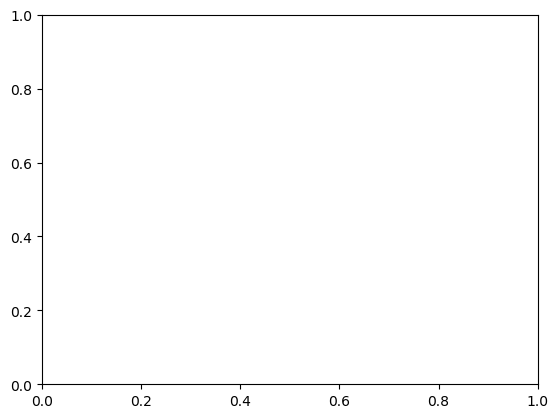

In [304]:
import matplotlib.pyplot as plt
from skimage import data
from skimage import filters
from skimage import exposure
from scipy.ndimage import gaussian_filter

plt.style.use('default')
np.random.seed(10)

dataset = 'bb'

X = loadmat('all'+dataset)['Z']
label_true = loadmat('2'+dataset+'_mask')['BW'] 
p = np.reshape(label_true, (20,68), order="F")

for jj in range(0,6):
    r2 = np.reshape(X[:,jj], (20,68), order="F")
    X[:,jj] = np.reshape(gaussian(r2,sigma=0.5),20*68,order="F")
    
X2 = PCA(n_components=2).fit_transform(X[:,1:])
    
camera = X[:,0].reshape((20,68), order='F')
    
val = filters.threshold_otsu(camera)

hist, bins_center = exposure.histogram(camera)

km = cluster.MiniBatchKMeans(n_clusters=2).fit_predict(X[:,1:])
km = km.reshape((20,68),order='F')

gmm = mixture.GaussianMixture(n_components=2,covariance_type='spherical').fit_predict(X2)
gmm = gmm.reshape((20,68),order='F')

bgmm = mixture.BayesianGaussianMixture(n_components=2,covariance_type='spherical').fit_predict(X2)
bgmm = bgmm.reshape((20,68),order='F')

plt.figure(figsize=[2,7])
plt.subplot(711)
plt.title('a) Image')
plt.imshow(camera, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(712)
plt.title('b) Otsu')
plt.imshow(-1*(camera < val), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(713)
plt.title('c) K-means')
plt.imshow(-1*km, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(714)
plt.title('d) GMM')
plt.imshow(gmm, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(715)
plt.title('e) BGMM')
plt.imshow(-1*bgmm, cmap='gray', interpolation='nearest')
plt.axis('off')

plt.subplot(716)
plt.title('f) IBGMM')
plt.imshow(-1*r, cmap='gray', interpolation='nearest')
plt.axis('off')

plt.subplot(717)
plt.title('f) Ground Truth')
plt.imshow(-1*p, cmap='gray', interpolation='nearest')
plt.axis('off')

plt.figure()
ax = plt.subplot(111)

out = mask_color_img(camera,abs(-1*km))
#plot_composite(abs(-1*km),camera,ax)
# plt.subplot(133)
# plt.plot(bins_center, hist, lw=2)
# plt.axvline(val, color='k', ls='--')

plt.tight_layout()
plt.show()
# plt.savefig('../../clustering_figures/otsu.png',dpi=300,format='png')

homo1,comp1,vs1 = homogeneity_completeness_v_measure(
    labels_true.squeeze(), np.reshape(camera < val,(1360),order="F").squeeze())
print(vs1)

In [307]:
from PIL import Image

def plot_composite(one,two,ax):
    def changeImageSize(maxWidth, 
                        maxHeight, 
                        image):

        widthRatio  = maxWidth/image.size[0]
        heightRatio = maxHeight/image.size[1]

        newWidth    = int(widthRatio*image.size[0])
        newHeight   = int(heightRatio*image.size[1])

        newImage    = image.resize((newWidth, newHeight))
        return newImage

    # Take two images for blending them together 
    
    two -= np.amin(two)
    two /= np.amax(two)
    
    plt.imsave("face.png",one*255, cmap="Purples")
    image1 = Image.open("face.png")
    image2 = Image.fromarray(two*255)

    # Make the images of uniform size
#     image3 = changeImageSize(800, 800, image1)
#     image4 = changeImageSize(800, 800, image2)

    # Make sure images got an alpha channel
    image5 = image1.convert("RGBA")
    image6 = image2.convert("RGBA")

    # Display the images
    #image5.show()
    #image6.show()

    # alpha-blend the images with varying values of alpha
    alphaBlended1 = Image.blend(image5, image6, alpha=.1)
    alphaBlended2 = Image.blend(image5, image6, alpha=.8)

    # Display the alpha-blended images
    #plt.figure()
    #plt.imshow(alphaBlended1)
    #plt.figure()
    #plt.imshow(alphaBlended2)


    ax.imshow(alphaBlended2)
    ax.set_title('c) Overlay',size = 10)
#     ax1.text(70,25,'2% Au',color=(1.0,0.65,0))
#     ax1.text(10,25,'5% Gd',color=(0,1.0,0))
#     ax1.text(45,115,'5% I',color=(1.0,0,1.0))
#     f.savefig('Figure5.eps',dpi=350)
    plt.show()
        
def mask_color_img(img, mask, color=[252,79,48], alpha=0.3):
    '''
    img: cv2 image
    mask: bool or np.where
    color: BGR triplet [_, _, _]. Default: [0, 255, 255] is yellow.
    alpha: float [0, 1]. 

    Ref: http://www.pyimagesearch.com/2016/03/07/transparent-overlays-with-opencv/
    '''
    out = img.copy()
    img_layer = img.copy()
    img_layer[mask] = color
    out = cv2.addWeighted(img_layer, alpha, out, 1 - alpha, 0, out)
    return(out)

ModuleNotFoundError: No module named 'cv2'

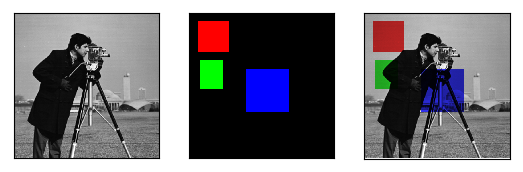

In [306]:
from skimage import data, color, io, img_as_float
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.8

img = img_as_float(data.camera())
rows, cols = img.shape

# Construct a colour image to superimpose
color_mask = np.zeros((rows, cols, 3))
color_mask[30:140, 30:140] = [1, 0, 0]  # Red block
color_mask[170:270, 40:120] = [0, 1, 0] # Green block
color_mask[200:350, 200:350] = [0, 0, 1] # Blue block

# Construct RGB version of grey-level image
img_color = np.dstack((img, img, img))

# Convert the input image and color mask to Hue Saturation Value (HSV)
# colorspace
img_hsv = color.rgb2hsv(img_color)
color_mask_hsv = color.rgb2hsv(color_mask)

# Replace the hue and saturation of the original image
# with that of the color mask
img_hsv[..., 0] = color_mask_hsv[..., 0]
img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

img_masked = color.hsv2rgb(img_hsv)

# Display the output
f, (ax0, ax1, ax2) = plt.subplots(1, 3,
                                  subplot_kw={'xticks': [], 'yticks': []})
ax0.imshow(img, cmap=plt.cm.gray)
ax1.imshow(color_mask)
ax2.imshow(img_masked)
plt.show()

In [79]:
0.41 + 

(1360,)

BIC got higher


UnboundLocalError: local variable 'y_pred' referenced before assignment

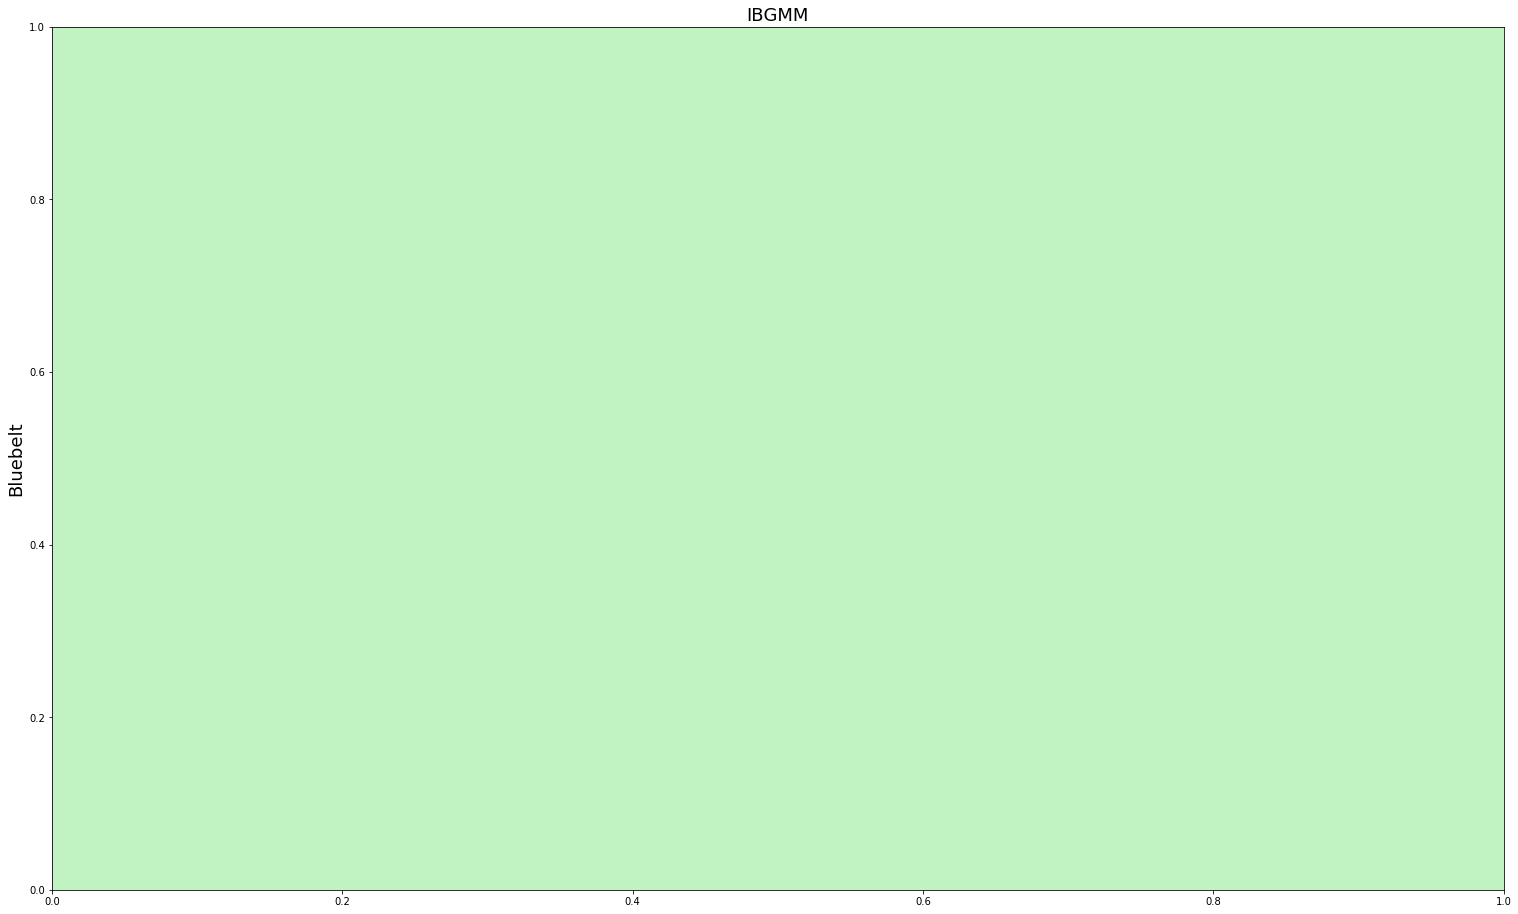

<Figure size 720x720 with 0 Axes>

In [16]:
plot_results(0,0,0,1,cinds=[11],dinds=[2])

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from clustering_comparison import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


BIC got higher
BIC got higher


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

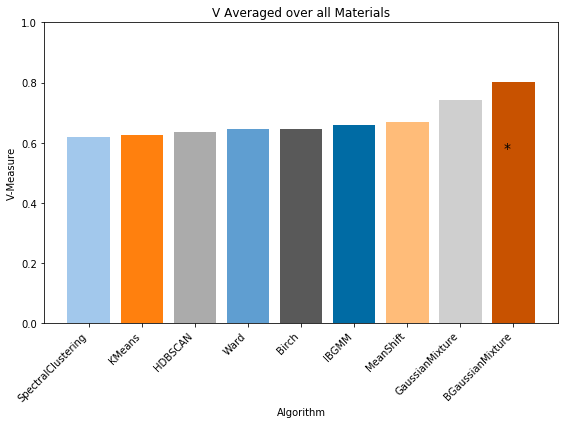

In [15]:
plot_results(0,0,0,1,cinds=[0,2,3,4,7,8,9,10,11],dinds=[0,4])

BIC got higher


<Figure size 720x720 with 0 Axes>

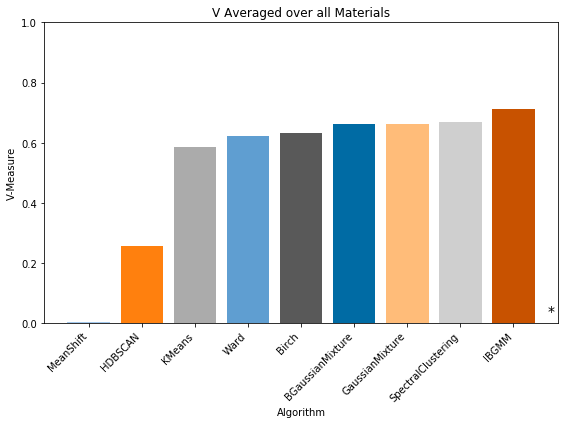

In [38]:
plot_results(0,0,0,1,cinds=[0,2,3,4,7,8,9,10,11],dinds=[2])